In [2]:
import os
import pandas as pd
import numpy as np
import altair as alt

from altair import datum

import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

In [3]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [4]:
my_theme = alt.themes.get()()
my_theme.setdefault('encoding', {}).setdefault('color', {})['scale'] = {'scheme': 'set1',}
alt.themes.register('my_theme', lambda: my_theme)
alt.themes.enable('my_theme')

ThemeRegistry.enable('my_theme')

In [5]:
# Read the data from the "data/" sibling directory
X = pd.read_csv(os.path.abspath('..') + '/data/log_expression.csv', index_col=[0])
y = pd.read_csv(os.path.abspath('..') + '/data/mayo_samples.csv', index_col=[0])

In [6]:
y = y.rename(columns={"AgeAtDeath":"Age_at_death"})

y["Tissue"] = y["Tissue"].replace({"TemporalCortex":"Temporal_Cortex"})
y["Age_at_death"] = y["Age_at_death"].replace({"90_or_above":"90"})
y["Gender"] = y["Gender"].replace({"M":"Male", "F":"Female"})

y["Age_at_death"] = y["Age_at_death"].astype(int)
y["ApoE"] = y["ApoE"].astype(object)

In [7]:
X = X.T

In [8]:
# Remove the "X" in front of the sample names
X.index = [i[1:] for i in X.index]
y.index = [i[1:] for i in y.index]

In [9]:
X.shape

(545, 43963)

In [11]:
pca = PCA().fit(X)

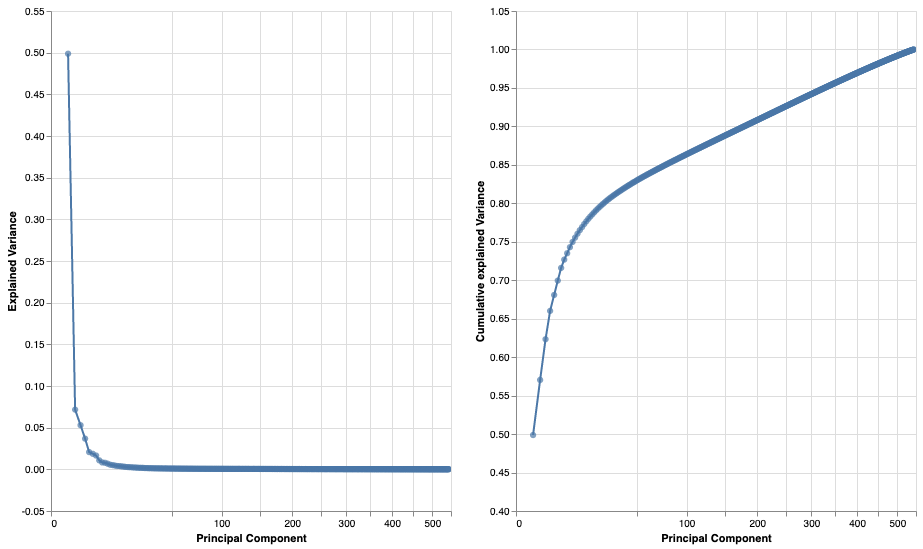

In [12]:
explained_variance = pd.DataFrame(pca.explained_variance_ratio_, columns=["variance"]).shift()[1:].reset_index()
explained_variance["cumulative"] = [sum(explained_variance[:i+1]["variance"]) for i in range(explained_variance.shape[0])]

line = alt.Chart(explained_variance).mark_line().encode(
    x=alt.X("index", scale=alt.Scale(type="sqrt"), title="Principal Component"),
    y=alt.Y("variance:Q", scale=alt.Scale(domain=(-0.001, 0.55)), title="Explained Variance")
).properties(height=500)

point = alt.Chart(explained_variance).mark_circle(size=40).encode(
    x=alt.X("index", scale=alt.Scale(type="sqrt"), title="Principal Component"),
    y=alt.Y("variance:Q", scale=alt.Scale(domain=(-0.001, 0.55)), title="Explained Variance"),
    tooltip=alt.Tooltip("index:O", title="Principal Component")
).interactive().properties(height=500)

e_v = line + point

line_c = alt.Chart(explained_variance).mark_line().encode(
    x=alt.X("index", scale=alt.Scale(type="sqrt"), title="Principal Component"),
    y=alt.Y("cumulative:Q", scale=alt.Scale(domain=(0.4, 1.001)), title="Cumulative explained Variance")
).properties(height=500)

point_c = alt.Chart(explained_variance).mark_circle(size=40).encode(
    x=alt.X("index", scale=alt.Scale(type="sqrt"), title="Principal Component"),
    y=alt.Y("cumulative:Q", scale=alt.Scale(domain=(0.4, 1.001)), title="Cumulative explained Variance"),
    tooltip=alt.Tooltip("index:O", title="Principal Component")
).interactive().properties(height=500)

c_e_v = line_c + point_c

alt.hconcat(
    e_v,
    c_e_v
)

In [14]:
np.cumsum(pca.explained_variance_ratio_)[:10]

array([0.49874418, 0.57038762, 0.62333571, 0.66015637, 0.68084922,
       0.69950484, 0.71602597, 0.72685272, 0.73509808, 0.74298873])

In [15]:
pcomp = pca.fit_transform(X)
pX = pd.DataFrame(data=pcomp[:,:8], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'], index=X.index)

In [16]:
pXt = pd.concat([pX, y], axis = 1).reset_index().rename(columns={"index": "Sample"})

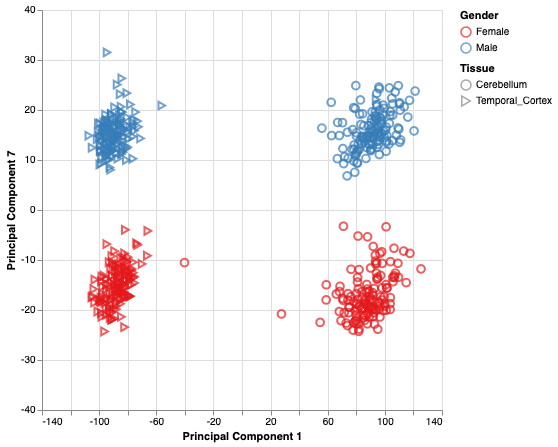

In [19]:
alt.Chart(pXt).mark_point(size=60).encode(
    x=alt.X("PC1:Q", scale=alt.Scale(domain=(-130, 130)), title="Principal Component 1"),
    y=alt.Y("PC7:Q", scale=alt.Scale(domain=(-40, 40)), title="Principal Component 7"),
    shape=alt.Shape("Tissue:N", title="Tissue", scale=alt.Scale(range=['circle', 'triangle-right'])),
    color=alt.Color("Gender:N", title="Gender"),
    tooltip=alt.Tooltip(["Sample:N", "Tissue:N", "Gender:N"])
).properties(width=400, height=400)

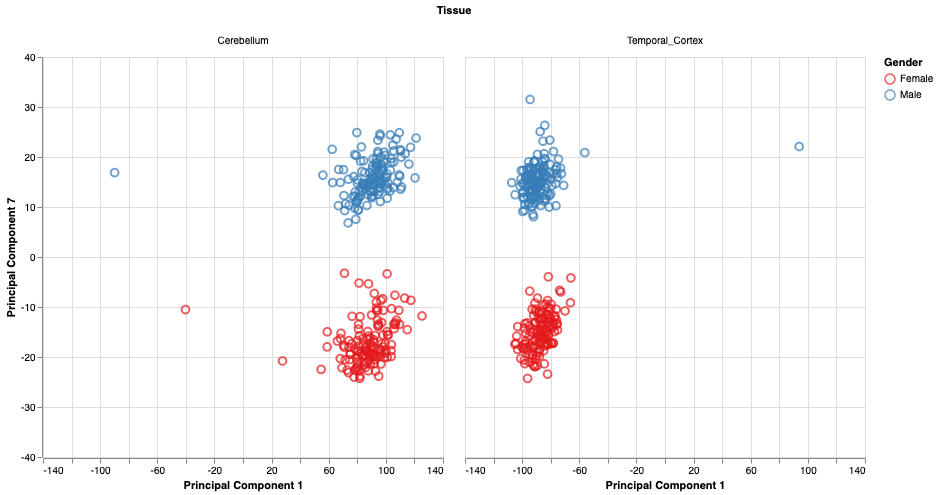

In [20]:
alt.Chart(pXt).mark_point(size=60).encode(
    x=alt.X("PC1:Q", scale=alt.Scale(domain=(-130, 130)), title="Principal Component 1"),
    y=alt.Y("PC7:Q", scale=alt.Scale(domain=(-40, 40)), title="Principal Component 7"),
    tooltip=alt.Tooltip(["Sample:N", "Tissue:N", "Gender:N"]),
    color=alt.Color("Gender:N", title="Gender"),
    column=alt.Column("Tissue:N", title="Tissue")
).properties(width=400, height=400)

[t-SNE] Computing 208 nearest neighbors...
[t-SNE] Indexed 545 samples in 1.131s...
[t-SNE] Computed neighbors for 545 samples in 39.021s...
[t-SNE] Computed conditional probabilities for sample 545 / 545
[t-SNE] Mean sigma: 29.422397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.495636
[t-SNE] KL divergence after 1000 iterations: 0.614322


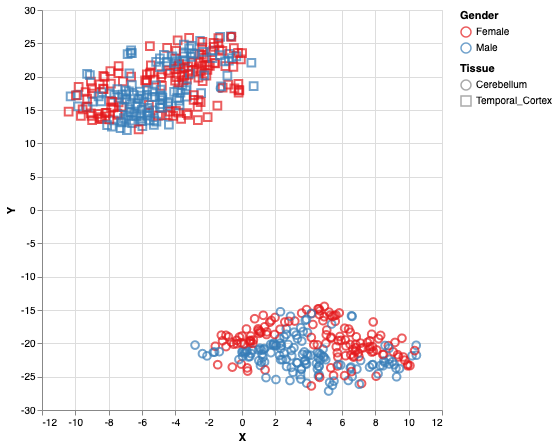

In [59]:
tsne = TSNE(perplexity=69.0, early_exaggeration=16.0, learning_rate=260.0, verbose=True).fit_transform(X)
tX = pd.DataFrame(data=tsne, columns=['x', 'y'], index=X.index)
tXt = pd.concat([tX, y], axis = 1).reset_index().rename(columns={"index": "Sample"})
alt.Chart(tXt).mark_point(size=60).encode(
    x=alt.X("x:Q", title="X"),
    y=alt.Y("y:Q", title="Y"),
    shape=alt.Shape("Tissue:N", title="Tissue"),
    color=alt.Color("Gender:N", title="Gender"),
    tooltip=alt.Tooltip(["Sample:N", "Tissue:N", "Gender:N", "Diagnosis:N"])
).properties(width=400, height=400)

[t-SNE] Computing 205 nearest neighbors...
[t-SNE] Indexed 545 samples in 0.965s...
[t-SNE] Computed neighbors for 545 samples in 25.823s...
[t-SNE] Computed conditional probabilities for sample 545 / 545
[t-SNE] Mean sigma: 29.330894
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.258324
[t-SNE] KL divergence after 1000 iterations: 0.560496


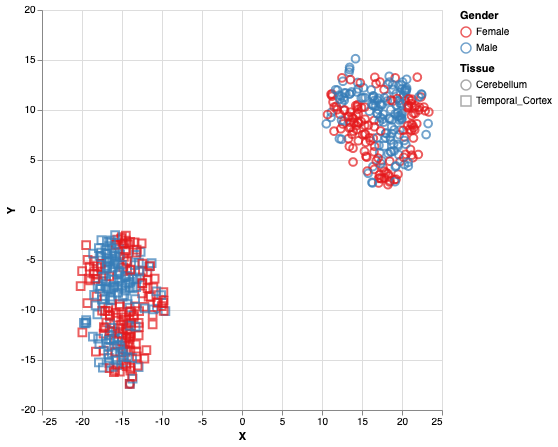

In [55]:
tsne = TSNE(perplexity=68.0, early_exaggeration=18.0, learning_rate=170.0, verbose=True).fit_transform(X)
tX = pd.DataFrame(data=tsne, columns=['x', 'y'], index=X.index)
tXt = pd.concat([tX, y], axis = 1).reset_index().rename(columns={"index": "Sample"})
alt.Chart(tXt).mark_point(size=60).encode(
    x=alt.X("x:Q", title="X"),
    y=alt.Y("y:Q", title="Y"),
    shape=alt.Shape("Tissue:N", title="Tissue"),
    color=alt.Color("Gender:N", title="Gender"),
    tooltip=alt.Tooltip(["Sample:N", "Tissue:N", "Gender:N", "Diagnosis:N"])
).properties(width=400, height=400)